In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
import seaborn as sns
sns.set(style='darkgrid')
import plotly.graph_objects as go

import sys
sys.path.append('../src') 

from scipy.stats import norm
from scipy.optimize import minimize

## Moving Averages and Bollinger Band -- Exploration

In [15]:
def plot_stock(stock_name,
               start=(datetime.today() - relativedelta(years=3)).strftime('%Y-%m-%d'),
               end=datetime.today(),
               figsize=(12, 6),
               interactive=False,
               return_result=False,
              ):
    '''
    Input:
    stock_name: str
    start: datetime
    end: datetime
    '''
    df = yf.download(stock_name.upper(),
                     start=start,
                     end=end)
    df = df.reset_index()
    df.columns = df.columns.str.lower()
    
    df['20 Day MA'] = df['close'].rolling(window=20).mean()
    df['20 Day STD'] = df['close'].rolling(window=20).std()
    df['50 Day MA'] = df['close'].rolling(window=50).mean()
    df['50 Day STD'] = df['close'].rolling(window=50).std()
    
    # Calculate upper and lower bands
    df['Upper Band - 20MA'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band - 20MA'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    df['Upper Band - 50MA'] = df['50 Day MA'] + (df['50 Day STD'] * 2.5)
    df['Lower Band - 50MA'] = df['50 Day MA'] - (df['50 Day STD'] * 2.5)

    close = df.iloc[-1]['close']
    print('* previous stock price closing', round(close,2))
    print("Latest 20 Day MA:", df['20 Day MA'].tolist()[-1])
    print("Latest Lower Bollinger Band - 20MA:", df['Lower Band - 20MA'].tolist()[-1])
    print("Latest Higher Bollinger Band - 20MA:", df['Upper Band - 20MA'].tolist()[-1])
    print("Latest Lower Bollinger Band - 50MA:", df['Lower Band - 50MA'].tolist()[-1])
    print("Latest Higher Bollinger Band - 50MA:", df['Upper Band - 50MA'].tolist()[-1])

    df_plot = df[df['date'] >= df['date'].min() + relativedelta(years=1)]
    if interactive:
        fig = go.Figure(layout=dict(width=figsize[0]*80, height=figsize[1]*80))
        
        fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['close'], name='Daily Price'))
        fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['20 Day MA'], mode='lines', line=dict(dash='dash'), name='20 Day MA'))
        fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['Lower Band - 20MA'], mode='lines', line=dict(dash='dash'), name='Lower Band - 20MA'))
        fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['Upper Band - 20MA'], mode='lines', line=dict(dash='dash'), name='Upper Band - 20MA', fill='tonexty', fillcolor='rgba(128,128,128,0.3)'))
        fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['50 Day MA'], mode='lines', line=dict(dash='dash'), name='50 Day MA'))
        fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['Lower Band - 50MA'], mode='lines', line=dict(dash='dash'), name='Lower Band - 50MA'))
        fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['Upper Band - 50MA'], mode='lines', line=dict(dash='dash'), name='Upper Band - 50MA', fill='tonexty', fillcolor='rgba(128,128,128,0.15)'))

        fig.update_layout(title='Interactive Plot of Daily Stock Price for ' + stock_name,
                          xaxis_title='date',
                          yaxis_title='Daily Price',
                          hovermode='closest')
        
        # Add ability to select a single data point
        fig.update_traces(marker=dict(size=10, opacity=0.8),
                          selector=dict(mode='markers'))
        
        fig.show()
    else:
        fig, ax = plt.subplots(figsize=figsize)
        ax.grid(True, alpha=0.5)
    
        ax.plot(df_plot['date'], df_plot['close'], label='Daily Close Price')
        ax.plot(df_plot['date'], df_plot['20 Day MA'], ls='--', label='20 Day Moving Average')
        ax.plot(df_plot['date'], df_plot['Upper Band - 20MA'], ls='--', label='Upper Bollinger Band - 20MA')
        ax.plot(df_plot['date'], df_plot['Lower Band - 20MA'], ls='--', label='Lower Bollinger Band - 20MA')
        ax.fill_between(df_plot['date'], df_plot['Upper Band - 20MA'], df_plot['Lower Band - 20MA'], color='gray', alpha=0.3) # Fill the area between the bands
        ax.plot(df_plot['date'], df_plot['50 Day MA'], ls='--', label='50 Day Moving Average')
        ax.plot(df_plot['date'], df_plot['Upper Band - 50MA'], ls='--', label='Upper Bollinger Band - 50MA')
        ax.plot(df_plot['date'], df_plot['Lower Band - 50MA'], ls='--', label='Lower Bollinger Band - 50MA')
        ax.fill_between(df_plot['date'], df_plot['Upper Band - 50MA'], df_plot['Lower Band - 50MA'], color='gray', alpha=0.15) # Fill the area between the bands
    
        ax.set_title('Daily stock price for ' + stock_name.upper())
        ax.legend()
    if return_result:
        return df

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 504.45
Latest 20 Day MA: 517.7324996948242
Latest Lower Bollinger Band - 20MA: 508.3620130418015
Latest Higher Bollinger Band - 20MA: 527.102986347847
Latest Lower Bollinger Band - 50MA: 487.56611415475743
Latest Higher Bollinger Band - 50MA: 532.5258853569613


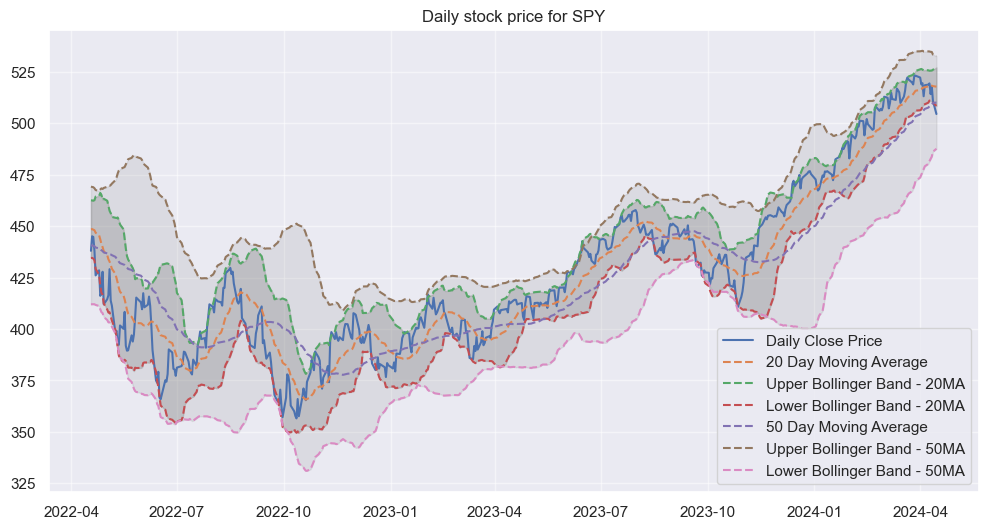

In [16]:
plot_stock('spy')

[*********************100%%**********************]  1 of 1 completed
high - open 95% confidence value: 0.011542681384914636
low - open 95% confidence value: -0.011909157150705571
close - open 95% confidence values - two-tail, using percentile: -0.011188135977700587 0.011216139894092205
close - open 95% confidence values - two-tail, using normal distribution: -0.011124284408816024 0.012133256857406582


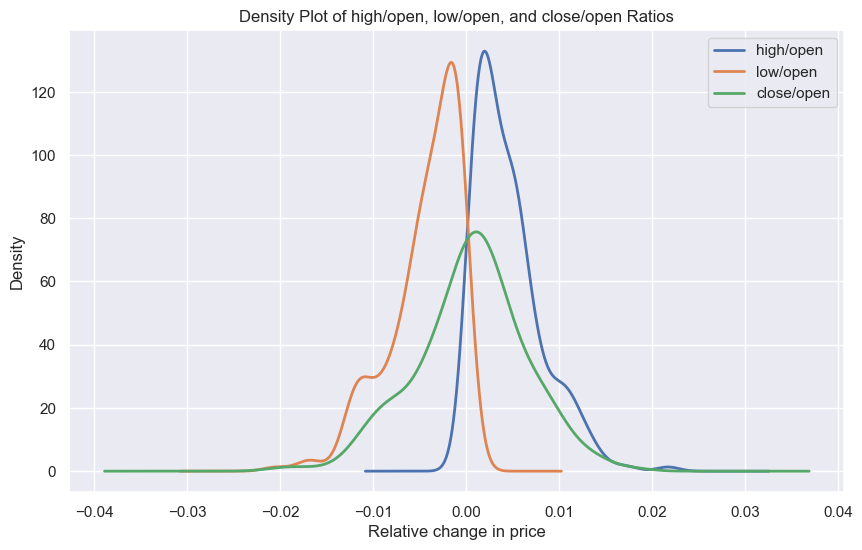

In [6]:
def daily_range_ci(df_stock):
	"""
	Plot the daily stock price range distribution, and return the 95% confidence interval
	input:
		df_stock: daily stock price; with columns lower cased
	"""
	print(
		'high - open 95% confidence value:',
		((df_stock['high']-df_stock['open'])/df_stock['open']).quantile(q=0.95)
		)
	print(
		'low - open 95% confidence value:',
		((df_stock['low']-df_stock['open'])/df_stock['open']).quantile(q=0.05)
		)
	print(
		'close - open 95% confidence values - two-tail, using percentile:',
		((df_stock['close']-df_stock['open'])/df_stock['open']).quantile(q=0.025),
		((df_stock['close']-df_stock['open'])/df_stock['open']).quantile(q=0.975)
		)
	print(
		'close - open 95% confidence values - two-tail, using normal distribution:',
		((df_stock['close'] - df_stock['open']) / df_stock['open']).mean() - 1.96*((df_stock['close'] - df_stock['open']) / df_stock['open']).std(),
		((df_stock['close'] - df_stock['open']) / df_stock['open']).mean() + 1.96*((df_stock['close'] - df_stock['open']) / df_stock['open']).std(),
		)


	plt.figure(figsize=(10, 6))
	# Density plot for high_open_ratio
	((df_stock['high']-df_stock['open'])/df_stock['open']).plot(kind='density', label='high/open', linewidth=2)

	# Density plot for low_open_ratio
	((df_stock['low']-df_stock['open'])/df_stock['open']).plot(kind='density', label='low/open', linewidth=2)

	# Density plot for close_open_ratio
	((df_stock['close']-df_stock['open'])/df_stock['open']).plot(kind='density', label='close/open', linewidth=2)

	plt.xlabel('Relative change in price')
	plt.ylabel('Density')
	plt.title('Density Plot of high/open, low/open, and close/open Ratios')
	plt.legend()
	plt.show()





df_spy = yf.download('spy'.upper(),
                     start=(datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d'),
                     end=datetime.today().strftime('%Y-%m-%d'))
df_spy = df_spy.reset_index()
df_spy.columns = df_spy.columns.str.lower()

daily_range_ci(df_spy)

## Brownian motion - exploration

In [7]:
df_spy = yf.download('spy'.upper(),
                     start=(datetime.today() - relativedelta(years=10)).strftime('%Y-%m-%d'),
                     end=datetime.today(),
                    )
df_spy = df_spy.reset_index()
df_spy.columns = df_spy.columns.str.lower()
print(df_spy.shape)
df_spy.head()

[*********************100%%**********************]  1 of 1 completed
(2517, 7)


,date,open,high,low,close,adj close,volume
0,2014-04-14,182.929993,183.369995,181.440002,182.940002,152.884705,132382000
1,2014-04-15,183.320007,184.330002,181.509995,184.199997,153.937698,157093000
2,2014-04-16,185.470001,186.139999,184.649994,186.130005,155.550598,105197000
3,2014-04-17,185.880005,186.910004,185.559998,186.389999,155.767883,105255000
4,2014-04-21,186.440002,187.100006,186.210007,187.039993,156.311096,68329000


In [8]:
# Generate synthetic daily stock price data for demonstration
np.random.seed(42)  # for reproducibility
num_days = df_spy.shape[0]  
initial_price = df_spy['close'][0]
drift = 0.05  # initial guess for drift
volatility = 0.2  # initial guess for volatility

# Generate synthetic daily stock price data
def generate_stock_prices(drift, volatility, initial_price, num_days):
    daily_returns = np.exp((drift - 0.5 * volatility**2) + volatility * norm.ppf(np.random.rand(num_days)))
    stock_prices = initial_price * pd.Series(daily_returns.cumprod(), name='Close')
    return stock_prices

# Log-likelihood function for GBM
def gbm_log_likelihood(params, prices):
    mu, sigma = params
    dt = 1  # time increment (1 day)
    returns = np.diff(np.log(prices))
    ll = -len(returns) / 2 * np.log(2 * np.pi) - len(returns) / 2 * np.log(sigma ** 2) - (1 / (2 * sigma ** 2)) * np.sum((returns - (mu - 0.5 * sigma ** 2) * dt) ** 2)
    return -ll

# Fit GBM parameters using MLE
def fit_gbm_params(prices):
    initial_guess = [0.05, 0.2]  # initial guess for drift and volatility
    result = minimize(gbm_log_likelihood, initial_guess, args=(prices,), bounds=((None, None), (0.001, None)))
    mu_mle, sigma_mle = result.x
    return mu_mle, sigma_mle

In [9]:
drift_mle, volatility_mle = fit_gbm_params(df_spy['close'])
print('Drift:', drift_mle)
print('Volatility:', volatility_mle)

Drift: 0.000470250910048103
Volatility: 0.011109896116592743


In [10]:
estimated_prices = generate_stock_prices(drift_mle, volatility_mle, initial_price, num_days)
estimated_prices

0       182.365562
1       185.819046
2       187.177484
3       187.774526
4       185.753184
           ...    
2512    499.049776
2513    499.398783
2514    501.398010
2515    509.745245
2516    498.346666
Name: Close, Length: 2517, dtype: float64

In [11]:
expectation_return = initial_price*np.exp(drift_mle*np.arange(start=0, stop=num_days))
expectation_return

array([182.94000244, 183.02605037, 183.11213878, ..., 596.67288472,
       596.95353667, 597.23432063])

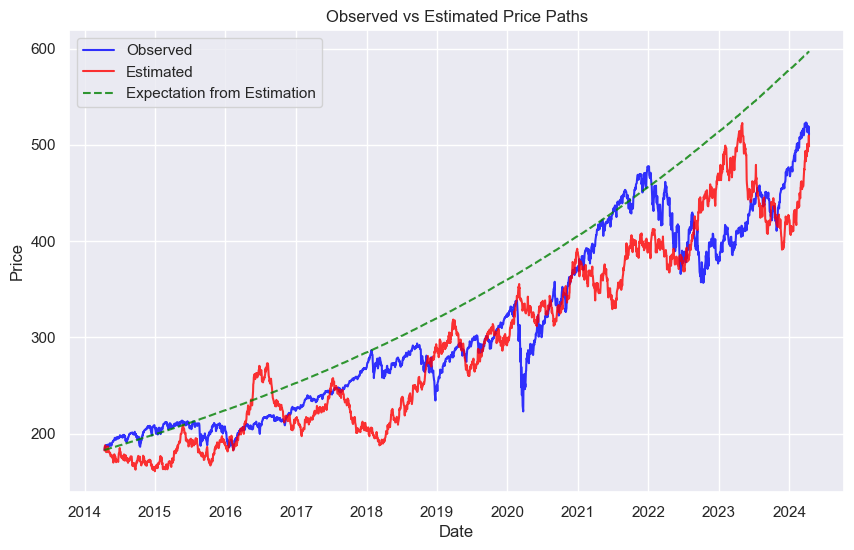

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(df_spy['date'], df_spy['close'], label='Observed', color='blue', alpha=0.8)
plt.plot(df_spy['date'], estimated_prices.values, label='Estimated', color='red', alpha=0.8)
plt.plot(df_spy['date'], expectation_return, label='Expectation from Estimation', color='green',linestyle='--', alpha=0.8)

plt.title('Observed vs Estimated Price Paths')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## MACD - exploration